# Doc2Vec with K-Means
## Reading data from CSV

In [1]:
import pandas as pd
from gensim.models.doc2vec import TaggedDocument
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns

from src.commons.parse_utils import parse_list_column

In [2]:
csv_file = "../../data/arxiv_processed.csv"
data = pd.read_csv(csv_file, sep=";", converters={'Processed Summary': parse_list_column})

In [3]:
data.head()

,ID,Title,Summary,Published,PDF Link,Processed Summary
0,http://arxiv.org/abs/cs/0002002v1,Uniform semantic treatment of default and auto...,We revisit the issue of connections between tw...,2000-02-03T21:44:57Z,http://arxiv.org/pdf/cs/0002002v1,"[revisit, issue, connection, two, leading, for..."
1,http://arxiv.org/abs/cs/0002003v1,On the accuracy and running time of GSAT,Randomized algorithms for deciding satisfiabil...,2000-02-04T12:53:57Z,http://arxiv.org/pdf/cs/0002003v1,"[randomized, algorithm, deciding, satisfiabili..."
2,http://arxiv.org/abs/cs/0002009v1,Syntactic Autonomy: Why There is no Autonomy w...,Two different types of agency are discussed ba...,2000-02-16T18:09:20Z,http://arxiv.org/pdf/cs/0002009v1,"[two, different, type, agency, discussed, base..."
3,http://arxiv.org/abs/cs/0003008v1,Consistency Management of Normal Logic Program...,This paper presents a method of computing a re...,2000-03-05T10:29:03Z,http://arxiv.org/pdf/cs/0003008v1,"[paper, present, method, computing, revision, ..."
4,http://arxiv.org/abs/cs/0003016v1,Abductive and Consistency-Based Diagnosis Revi...,Diagnostic reasoning has been characterized lo...,2000-03-07T11:39:53Z,http://arxiv.org/pdf/cs/0003016v1,"[diagnostic, reasoning, characterized, logical..."


## Training Doc2Vec model

In [4]:
from gensim.models import Doc2Vec

tagged_data = [TaggedDocument(words=row['Processed Summary'], tags=[str(index)]) for index, row in data.iterrows()]

model = Doc2Vec(vector_size=100, window=5, min_count=1, workers=4, epochs=20)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

In [5]:
model.save('topic_model')

## Clustering with K-Means

In [6]:
kmeans = KMeans(n_clusters=35, init='k-means++', max_iter=300, n_init=10, random_state=0)

In [7]:
y_kmeans = kmeans.fit_predict(model.dv.vectors)

In [8]:
data['Topic'] = y_kmeans

In [9]:
data.head()

,ID,Title,Summary,Published,PDF Link,Processed Summary,Topic
0,http://arxiv.org/abs/cs/0002002v1,Uniform semantic treatment of default and auto...,We revisit the issue of connections between tw...,2000-02-03T21:44:57Z,http://arxiv.org/pdf/cs/0002002v1,"[revisit, issue, connection, two, leading, for...",19
1,http://arxiv.org/abs/cs/0002003v1,On the accuracy and running time of GSAT,Randomized algorithms for deciding satisfiabil...,2000-02-04T12:53:57Z,http://arxiv.org/pdf/cs/0002003v1,"[randomized, algorithm, deciding, satisfiabili...",4
2,http://arxiv.org/abs/cs/0002009v1,Syntactic Autonomy: Why There is no Autonomy w...,Two different types of agency are discussed ba...,2000-02-16T18:09:20Z,http://arxiv.org/pdf/cs/0002009v1,"[two, different, type, agency, discussed, base...",1
3,http://arxiv.org/abs/cs/0003008v1,Consistency Management of Normal Logic Program...,This paper presents a method of computing a re...,2000-03-05T10:29:03Z,http://arxiv.org/pdf/cs/0003008v1,"[paper, present, method, computing, revision, ...",19
4,http://arxiv.org/abs/cs/0003016v1,Abductive and Consistency-Based Diagnosis Revi...,Diagnostic reasoning has been characterized lo...,2000-03-07T11:39:53Z,http://arxiv.org/pdf/cs/0003016v1,"[diagnostic, reasoning, characterized, logical...",32


### Visualizing clusters

In [10]:
X_embedded = TSNE(n_components=2).fit_transform(model.dv.vectors)

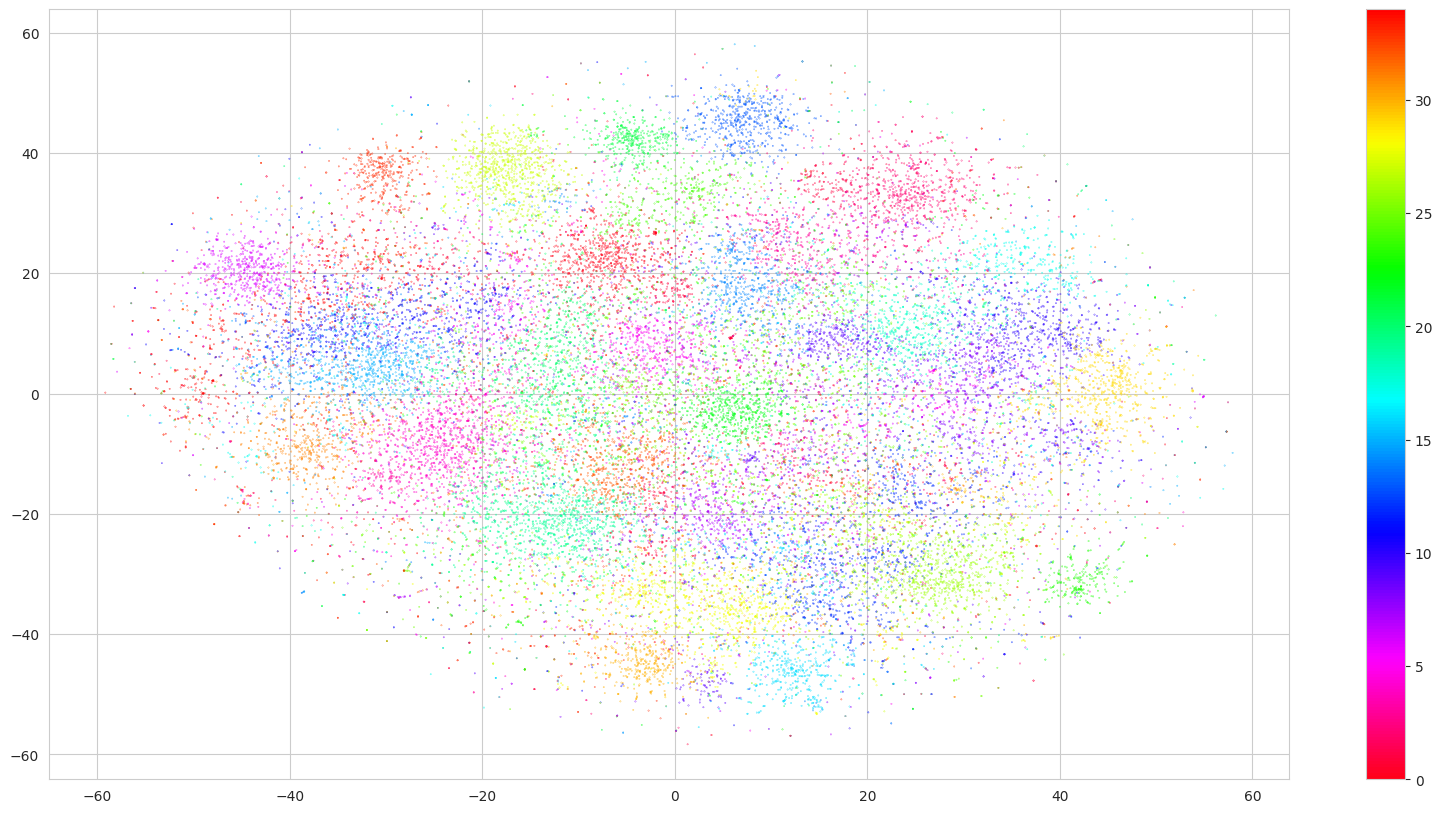

In [11]:
plt.figure(figsize=(20, 10))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_kmeans, s=0.05, cmap='hsv_r')
plt.colorbar()
plt.show()

#### Topic 0 exploration
##### Visualization

In [12]:
topic1_embedded = X_embedded[y_kmeans == 0]

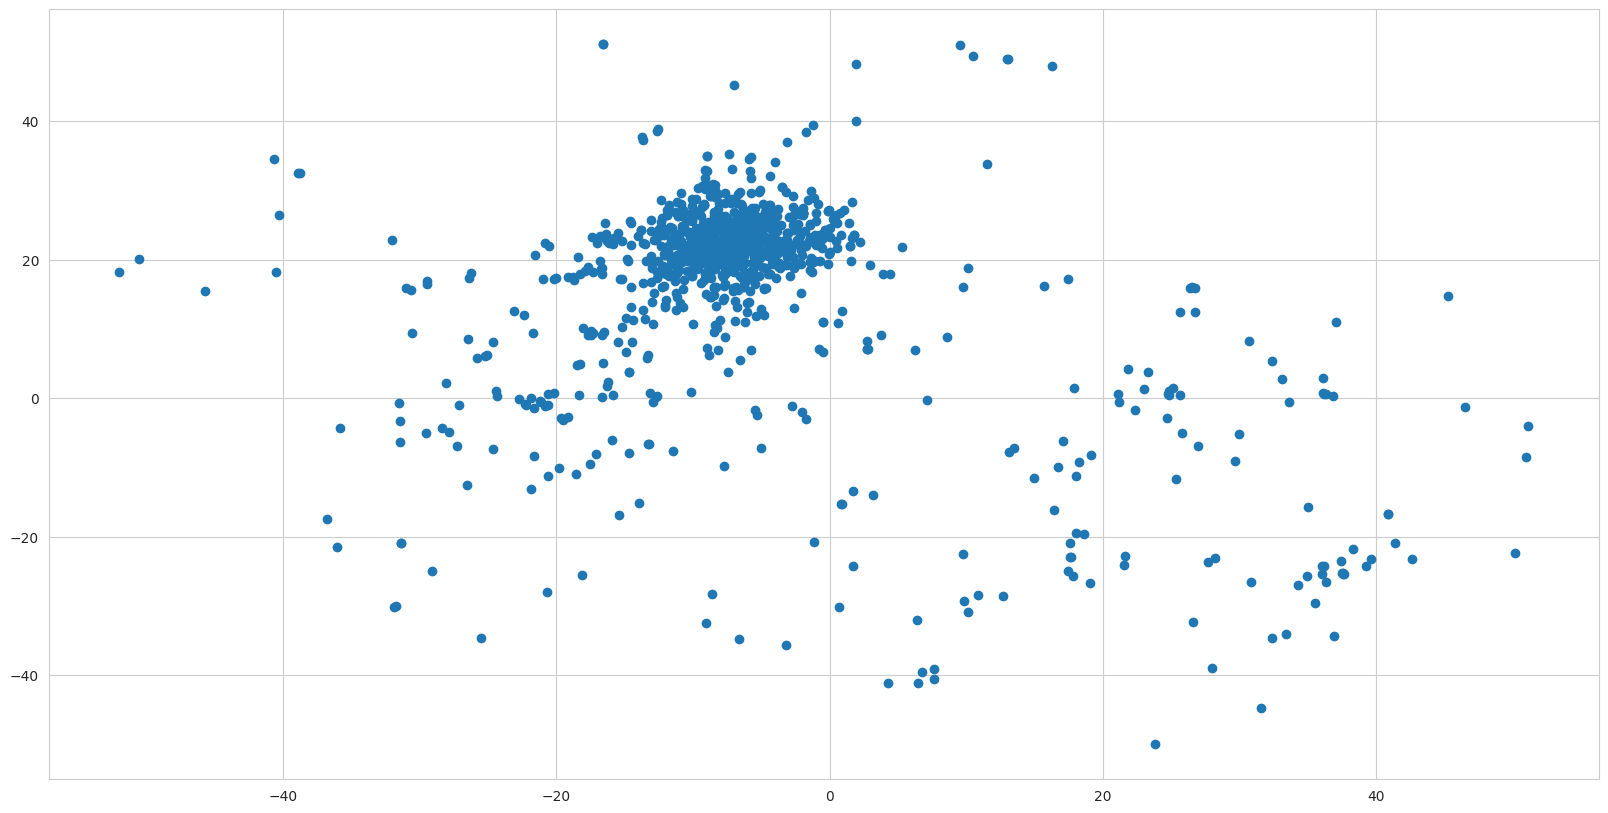

In [13]:
plt.figure(figsize=(20, 10))
plt.scatter(topic1_embedded[:, 0], topic1_embedded[:, 1])
plt.show()

##### Words

In [14]:
processed_summaries = []
for summary in data['Processed Summary']:
    processed_summaries.append(' '.join(summary))

docs_df = pd.DataFrame(processed_summaries, columns=["Doc"])
docs_df['Topic'] = y_kmeans
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [15]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

In [16]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

In [17]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df)
topic_sizes.head(10)

,Topic,Size
25,25,1514
20,20,1399
4,4,1389
26,26,1360
28,28,1280
12,12,1279
5,5,1276
19,19,1214
11,11,1193
7,7,1187


In [18]:
# topic 0 size
topic_sizes[topic_sizes['Topic'] == 0]

,Topic,Size
0,0,1090


In [19]:
top10_words_topic0 =  [i[0] for i in  top_n_words[0][:10]]
print(top10_words_topic0)

['pruning', 'quantization', 'architecture', 'parameter', 'layer', 'training', 'weight', 'compression', 'accuracy', 'memory']


Some 10 examples summaries from cluster 0:

In [20]:
topic0_docs = data[data['Topic'] == 0]

In [21]:
for index, row in topic0_docs.head(10).iterrows():
    print(f"Document ID: {row['ID']}")
    print(f"Title: {row['Title']}")
    print(f"Summary: {row['Summary']}")
    print(f"Topic: {row['Topic']}")
    print("-" * 80)

Document ID: http://arxiv.org/abs/cs/0405032v1
Title: EvoNF: A Framework for Optimization of Fuzzy Inference Systems Using   Neural Network Learning and Evolutionary Computation
Summary: Several adaptation techniques have been investigated to optimize fuzzy inference systems. Neural network learning algorithms have been used to determine the parameters of fuzzy inference system. Such models are often called as integrated neuro-fuzzy models. In an integrated neuro-fuzzy model there is no guarantee that the neural network learning algorithm converges and the tuning of fuzzy inference system will be successful. Success of evolutionary search procedures for optimization of fuzzy inference system is well proven and established in many application areas. In this paper, we will explore how the optimization of fuzzy inference systems could be further improved using a meta-heuristic approach combining neural network learning and evolutionary computation. The proposed technique could be consider

In [22]:
top10_words_topic10 = [i[0] for i in  top_n_words[10][:10]]
print(top10_words_topic10)

['object', '3d', 'scene', 'pose', 'point', 'segmentation', 'camera', 'depth', 'tracking', 'map']


In [23]:
topic10_docs = data[data['Topic'] == 10]

In [24]:
for index, row in topic10_docs.head(10).iterrows():
    print(f"Document ID: {row['ID']}")
    print(f"Title: {row['Title']}")
    print(f"Summary: {row['Summary']}")
    print(f"Topic: {row['Topic']}")
    print("-" * 80)

Document ID: http://arxiv.org/abs/cs/0303018v1
Title: Multi-target particle filtering for the probability hypothesis density
Summary: When tracking a large number of targets, it is often computationally expensive to represent the full joint distribution over target states. In cases where the targets move independently, each target can instead be tracked with a separate filter. However, this leads to a model-data association problem. Another approach to solve the problem with computational complexity is to track only the first moment of the joint distribution, the probability hypothesis density (PHD). The integral of this distribution over any area S is the expected number of targets within S. Since no record of object identity is kept, the model-data association problem is avoided.   The contribution of this paper is a particle filter implementation of the PHD filter mentioned above. This PHD particle filter is applied to tracking of multiple vehicles in terrain, a non-linear tracking 

In [25]:
for i in range(35):
    print(f"Topic {i} size: {topic_sizes[topic_sizes['Topic'] == i]['Size'].values[0]}")
    print(f"Top 10 words: {[i[0] for i in  top_n_words[i][:10]]}")

Topic 0 size: 1090
Top 10 words: ['pruning', 'quantization', 'architecture', 'parameter', 'layer', 'training', 'weight', 'compression', 'accuracy', 'memory']
Topic 1 size: 1100
Top 10 words: ['cognitive', 'intelligence', 'human', 'artificial', 'brain', 'theory', 'concept', 'machine', 'ai', 'computational']
Topic 2 size: 1109
Top 10 words: ['ai', 'ethical', 'technology', 'intelligence', 'artificial', 'research', 'ethic', 'human', 'development', 'risk']
Topic 3 size: 805
Top 10 words: ['vehicle', 'traffic', 'road', 'driving', 'demand', 'transportation', 'control', 'city', 'time', 'management']
Topic 4 size: 1389
Top 10 words: ['search', 'optimization', 'solution', 'problem', 'algorithm', 'heuristic', 'solver', 'constraint', 'instance', 'solving']
Topic 5 size: 1276
Top 10 words: ['label', 'class', 'sample', 'domain', 'training', 'classification', 'classifier', 'datasets', 'target', 'distribution']
Topic 6 size: 699
Top 10 words: ['game', 'player', 'agent', 'playing', 'play', 'level', 'st

### Topic Trend by quarter

In [26]:
# aggregate the amount of articles per topic per quarter
data['Published'] = pd.to_datetime(data['Published'])
data['Quarter'] = data['Published'].dt.to_period("Q")



/tmp/ipykernel_15395/1100420561.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['Quarter'] = data['Published'].dt.to_period("Q")


In [27]:
data['Year'] = data['Published'].dt.year

In [28]:
topic_trend = data.groupby(['Quarter', 'Topic']).size().reset_index(name='Count')


In [29]:
topic_trend.head()

,Quarter,Topic,Count
0,2000Q1,1,1
1,2000Q1,4,1
2,2000Q1,19,13
3,2000Q1,31,2
4,2000Q1,32,2


In [30]:
topic_trend_yr = data.groupby(['Year', 'Topic']).size().reset_index(name='Count')
topic_trend_yr_pivot = topic_trend_yr.pivot(index='Year', columns='Topic', values='Count').fillna(0)
topic_trend_yr_pivot = topic_trend_yr_pivot.sort_index()

In [31]:
# for topic rename to a concatenated string of top 3 words
topic_trend_yr_pivot.columns = [' '.join([word[0] for word in top_n_words[i][:3]]) for i in range(35)]

In [32]:
topic_trend_yr_pivot.head()

,pruning quantization architecture,cognitive intelligence human,ai ethical technology,vehicle traffic road,search optimization solution,label class sample,game player agent,ontology knowledge development,feature segmentation image,patient clinical medical,...,classification technique machine,language translation multilingual,graph node gnns,question llm answer,image diffusion generation,dialogue response conversation,planning plan action,belief probability decision,recommendation user item,agent environment reinforcement
Year,,,,,,,,,,,,,,,,,,,,,
2000,0.0,2.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,2.0
2001,1.0,0.0,1.0,0.0,3.0,1.0,1.0,6.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0
2002,0.0,5.0,0.0,0.0,2.0,0.0,1.0,2.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,3.0,6.0,0.0,3.0
2003,2.0,7.0,0.0,0.0,2.0,0.0,1.0,3.0,0.0,0.0,...,6.0,3.0,2.0,0.0,0.0,1.0,4.0,15.0,0.0,1.0
2004,2.0,16.0,0.0,2.0,11.0,0.0,1.0,1.0,0.0,0.0,...,16.0,0.0,3.0,2.0,0.0,0.0,1.0,7.0,4.0,1.0


In [33]:
topic_trend_pivot = topic_trend.pivot(index='Quarter', columns='Topic', values='Count').fillna(0)

In [34]:
topic_trend_pivot.head()

Topic,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
Quarter,,,,,,,,,,,,,,,,,,,,,
2000Q1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0
2000Q2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2000Q3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2000Q4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2001Q1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [35]:
pivoted_data = topic_trend_pivot.sort_index()

In [36]:
import matplotlib.animation as animation

Animation saved as top_topics_over_time.gif


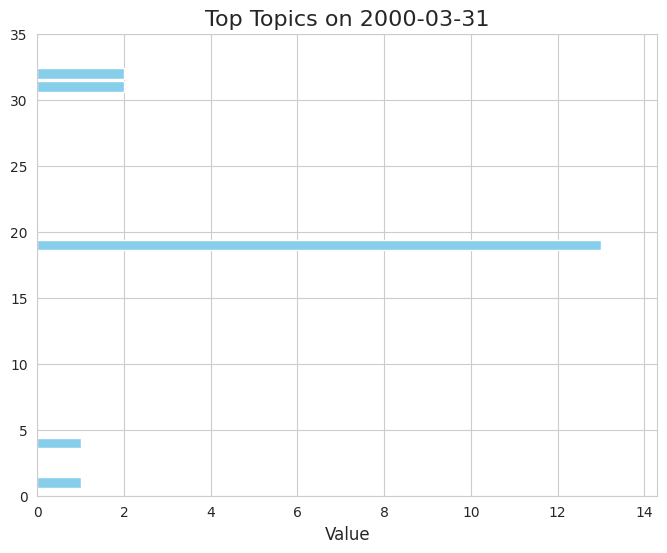

In [37]:
fig, ax = plt.subplots(figsize=(8, 6))

# set y lim to show 0-35
ax.set_ylim(0, 35)

def update(frame):
    ax.clear()
    current_data = pivoted_data.iloc[:frame + 1].iloc[-1]
    current_data = current_data.sort_values(ascending=False)
    current_data = current_data.head(10)  # Show only top 10 topics
    
    ax.barh(current_data.index, current_data.values, color='skyblue')
    ax.set_title(f"Top Topics on {pivoted_data.index[frame].strftime('%Y-%m-%d')}", fontsize=16)
    ax.set_xlabel('Value', fontsize=12)
    ax.set_xlim(0, current_data.max() * 1.1)
    ax.set_ylim(0, 35)
    
ani = animation.FuncAnimation(fig, update, frames=len(pivoted_data), interval=500)

# Save as GIF
output_gif_path = 'top_topics_over_time.gif'
ani.save(output_gif_path, writer='pillow', fps=10)

print(f"Animation saved as {output_gif_path}")

In [38]:
!pip install bar_chart_race

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


In [39]:
import bar_chart_race as bcr

In [40]:
bcr.bar_chart_race(df=pivoted_data, filename='topic_trend.gif', n_bars=10, title='Top 10 Topics by Quarter')

/home/mstrzezon/miniconda3/envs/adm/lib/python3.9/site-packages/bar_chart_race/_make_chart.py:889: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_values.iloc[:, 0] = df_values.iloc[:, 0].fillna(method='ffill')
/home/mstrzezon/miniconda3/envs/adm/lib/python3.9/site-packages/bar_chart_race/_make_chart.py:286: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(self.df_values.columns)
/home/mstrzezon/miniconda3/envs/adm/lib/python3.9/site-packages/bar_chart_race/_make_chart.py:287: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([max_val] * len(ax.get_xticks()))
/home/mstrzezon/miniconda3/envs/adm/lib/python3.9/site-packages/bar_chart_race/_make_chart.py:226: UserWarning: Some of your columns never make a

In [52]:
bcr.bar_chart_race(df=topic_trend_yr_pivot, 
                   filename='topic_trend.mp4',
                   n_bars=10,
                   title='Top 10 Topics by Year', 
                   interpolate_period=True, 
                   steps_per_period=160,
                   period_fmt='{x:10.2f}',
                   period_length=10000)

/home/mstrzezon/miniconda3/envs/adm/lib/python3.9/site-packages/bar_chart_race/_make_chart.py:286: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(self.df_values.columns)
/home/mstrzezon/miniconda3/envs/adm/lib/python3.9/site-packages/bar_chart_race/_make_chart.py:287: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([max_val] * len(ax.get_xticks()))
/home/mstrzezon/miniconda3/envs/adm/lib/python3.9/site-packages/bar_chart_race/_make_chart.py:226: UserWarning: Some of your columns never make an appearance in the animation. To reduce color repetition, set `filter_column_colors` to `True`
  warnings.warn("Some of your columns never make an appearance in the animation. "


In [38]:
val = 20.137
print(f"val:,.0f")

val:,.0f


### Topic Trend by year


In [26]:
data['Year'] = pd.to_datetime(data['Published']).dt.year

In [27]:
topic_trend = data.groupby(['Year', 'Topic']).size().reset_index(name='Count')

In [28]:
topic_trend.head()

,Year,Topic,Count
0,2000,0,1
1,2000,2,2
2,2000,7,2
3,2000,12,1
4,2000,13,20


In [28]:
topic_trend_pivot = topic_trend.pivot(index='Year', columns='Topic', values='Count').fillna(0)

In [29]:
topic_trend_pivot.head()

Topic,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
Year,,,,,,,,,,,,,,,,,,,,,
2000,2.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,22.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,1.0,1.0,0.0,0.0
2002,3.0,0.0,2.0,0.0,0.0,1.0,3.0,0.0,34.0,1.0,...,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,3.0,0.0
2003,3.0,2.0,4.0,3.0,0.0,1.0,1.0,2.0,23.0,1.0,...,0.0,0.0,1.0,5.0,0.0,0.0,1.0,0.0,10.0,0.0
2004,2.0,2.0,4.0,6.0,1.0,1.0,3.0,2.0,15.0,2.0,...,0.0,1.0,3.0,4.0,0.0,0.0,3.0,0.0,7.0,0.0


Normalize it by number of articles in year

In [30]:
# Normalize topic_trend_pivot by number of articles in year
total_articles_per_year = topic_trend_pivot.sum(axis=1)

topic_trend_pivot_normalized = topic_trend_pivot.div(total_articles_per_year, axis=0)

topic_trend_pivot_normalized.head()

Topic,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
Year,,,,,,,,,,,,,,,,,,,,,
2000,0.054054,0.027027,0.027027,0.027027,0.000000,0.000000,0.054054,0.000000,0.594595,0.000000,...,0.0,0.027027,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
2001,0.030303,0.060606,0.030303,0.000000,0.000000,0.030303,0.000000,0.000000,0.181818,0.000000,...,0.0,0.000000,0.000000,0.151515,0.0,0.0,0.030303,0.030303,0.000000,0.0
2002,0.044118,0.000000,0.029412,0.000000,0.000000,0.014706,0.044118,0.000000,0.500000,0.014706,...,0.0,0.000000,0.000000,0.029412,0.0,0.0,0.014706,0.000000,0.044118,0.0
2003,0.038462,0.025641,0.051282,0.038462,0.000000,0.012821,0.012821,0.025641,0.294872,0.012821,...,0.0,0.000000,0.012821,0.064103,0.0,0.0,0.012821,0.000000,0.128205,0.0
2004,0.019417,0.019417,0.038835,0.058252,0.009709,0.009709,0.029126,0.019417,0.145631,0.019417,...,0.0,0.009709,0.029126,0.038835,0.0,0.0,0.029126,0.000000,0.067961,0.0


In [31]:
from sklearn.preprocessing import MinMaxScaler

# Normalize topic_trend_pivot_normalized to 0-1 range
scaler = MinMaxScaler()
topic_trend_pivot_normalized_0_1 = pd.DataFrame(scaler.fit_transform(topic_trend_pivot_normalized),
                                                index=topic_trend_pivot_normalized.index,
                                                columns=topic_trend_pivot_normalized.columns)

topic_trend_pivot_normalized_0_1.head()

Topic,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
Year,,,,,,,,,,,,,,,,,,,,,
2000,0.412181,0.445946,0.306306,0.232432,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.0,0.783140,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
2001,0.201809,1.000000,0.377778,0.000000,0.000000,0.491717,0.000000,0.000000,0.288632,0.000000,...,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.643939,0.719488,0.000000,0.0
2002,0.324170,0.000000,0.358333,0.000000,0.000000,0.238627,0.816176,0.000000,0.836978,0.380788,...,0.0,0.000000,0.000000,0.194118,0.0,0.0,0.312500,0.000000,0.237379,0.0
2003,0.274072,0.423077,0.835470,0.330769,0.000000,0.208034,0.237179,0.630789,0.483466,0.331969,...,0.0,0.000000,0.264902,0.423077,0.0,0.0,0.272436,0.000000,0.689820,0.0
2004,0.105391,0.320388,0.563916,0.500971,0.119405,0.157540,0.538835,0.477685,0.226268,0.502789,...,0.0,0.281322,0.601817,0.256311,0.0,0.0,0.618932,0.000000,0.365672,0.0


<Axes: xlabel='Year'>

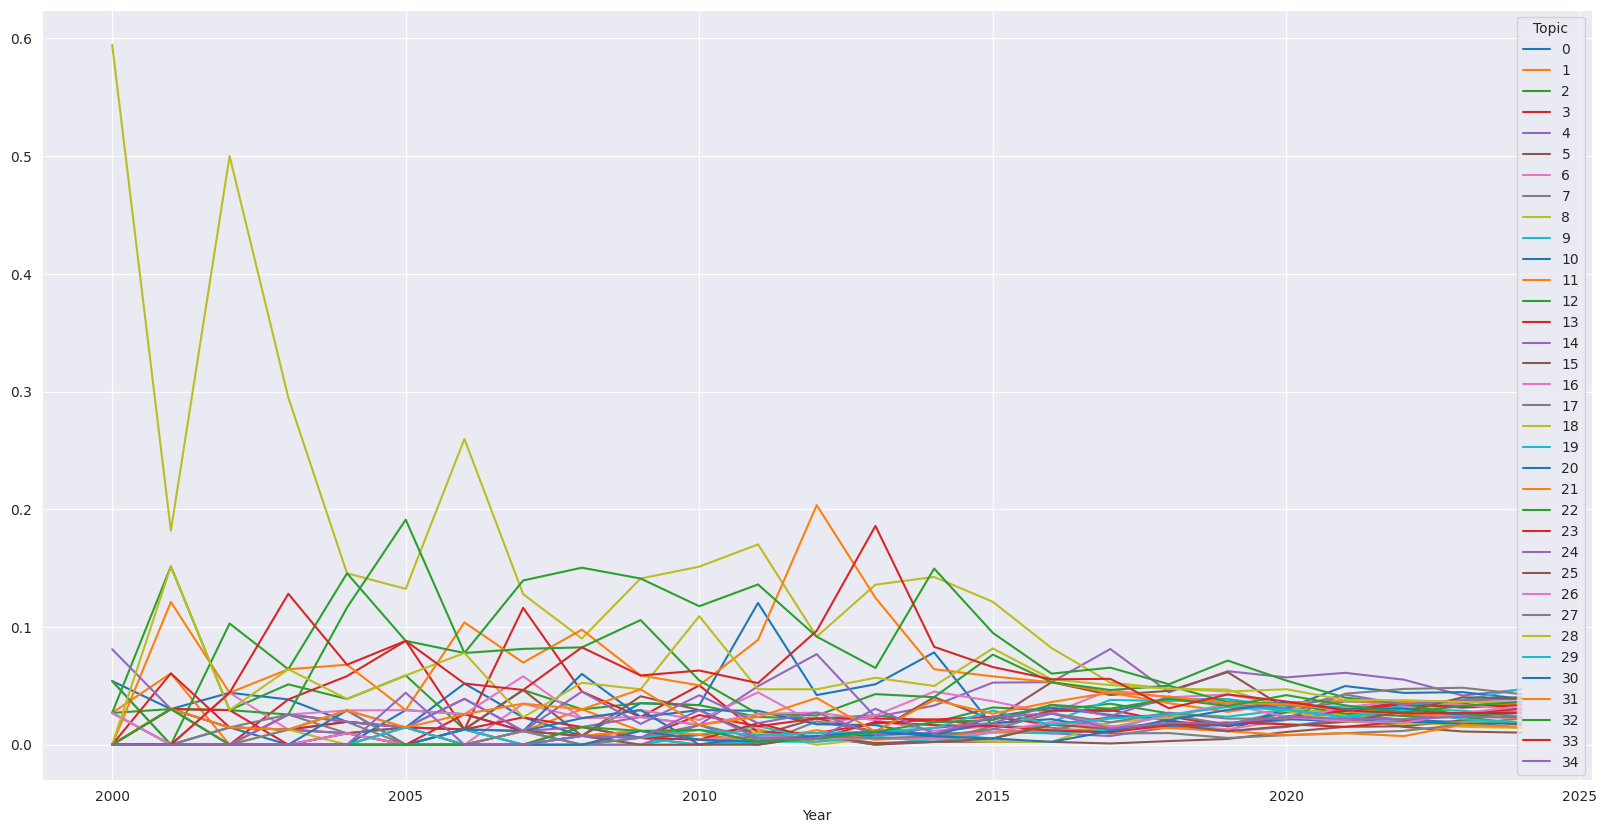

In [32]:
topic_trend_pivot_normalized.plot(kind='line', figsize=(20, 10))

<Axes: xlabel='Year'>

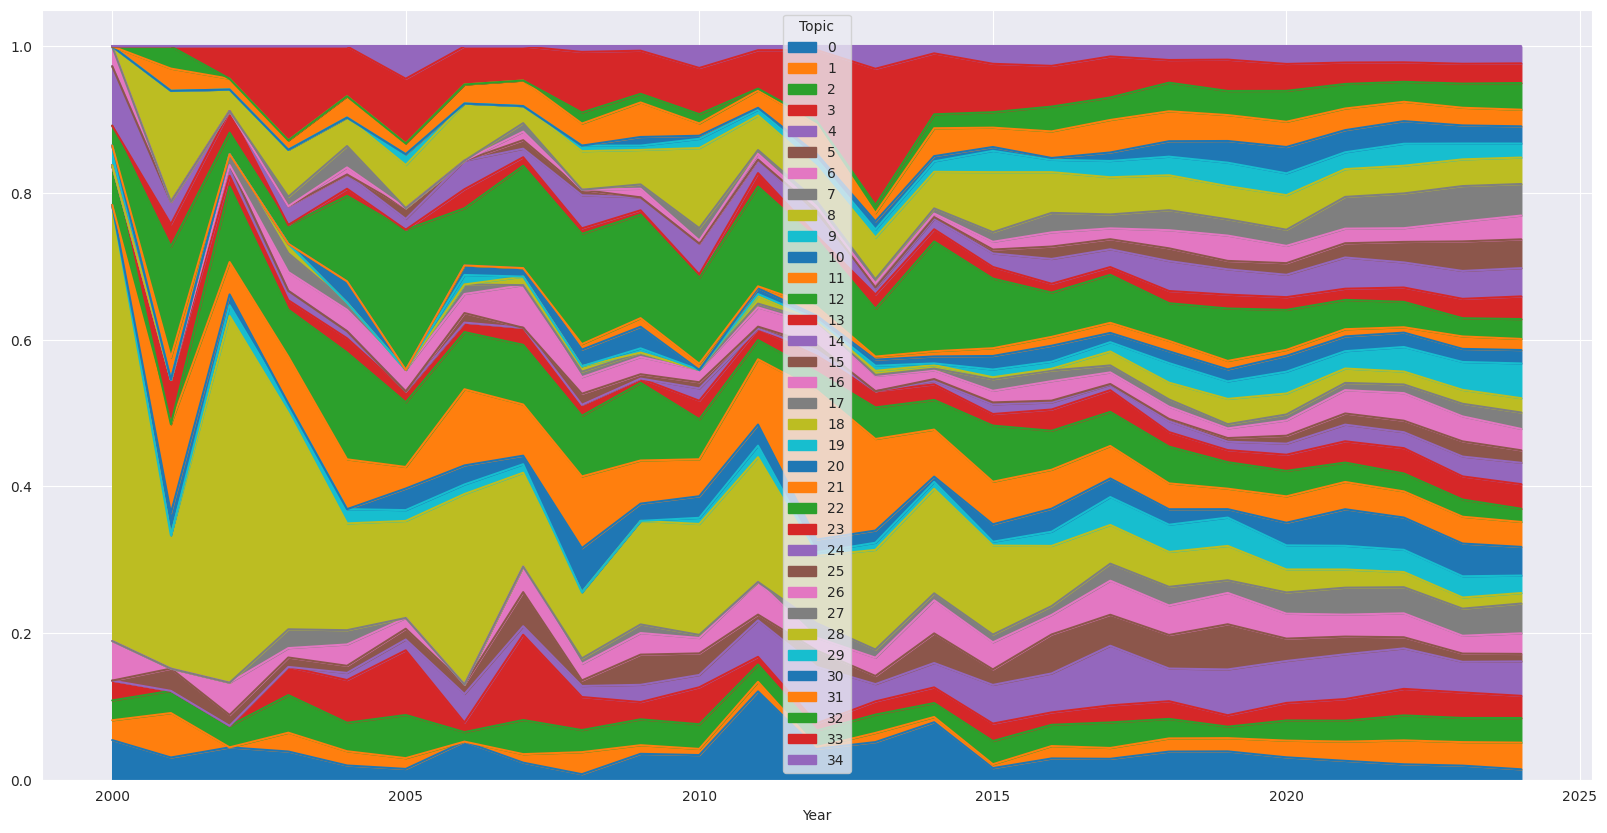

In [33]:
topic_trend_pivot_normalized.plot(kind='area', figsize=(20, 10))

<Axes: xlabel='Year'>

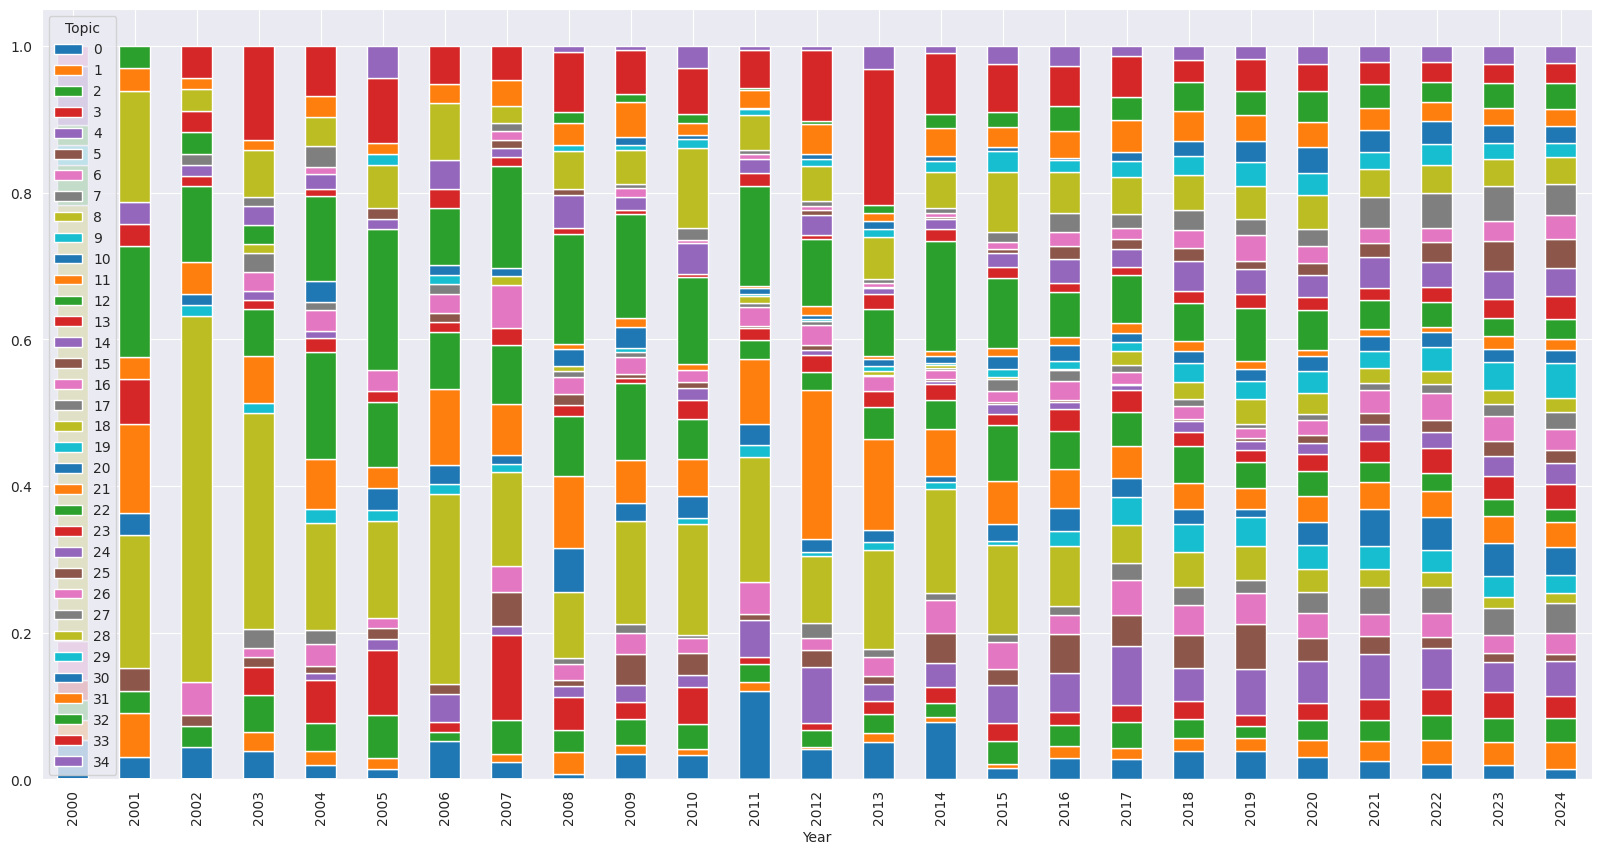

In [34]:
topic_trend_pivot_normalized.plot(kind='bar', stacked=True, figsize=(20, 10))

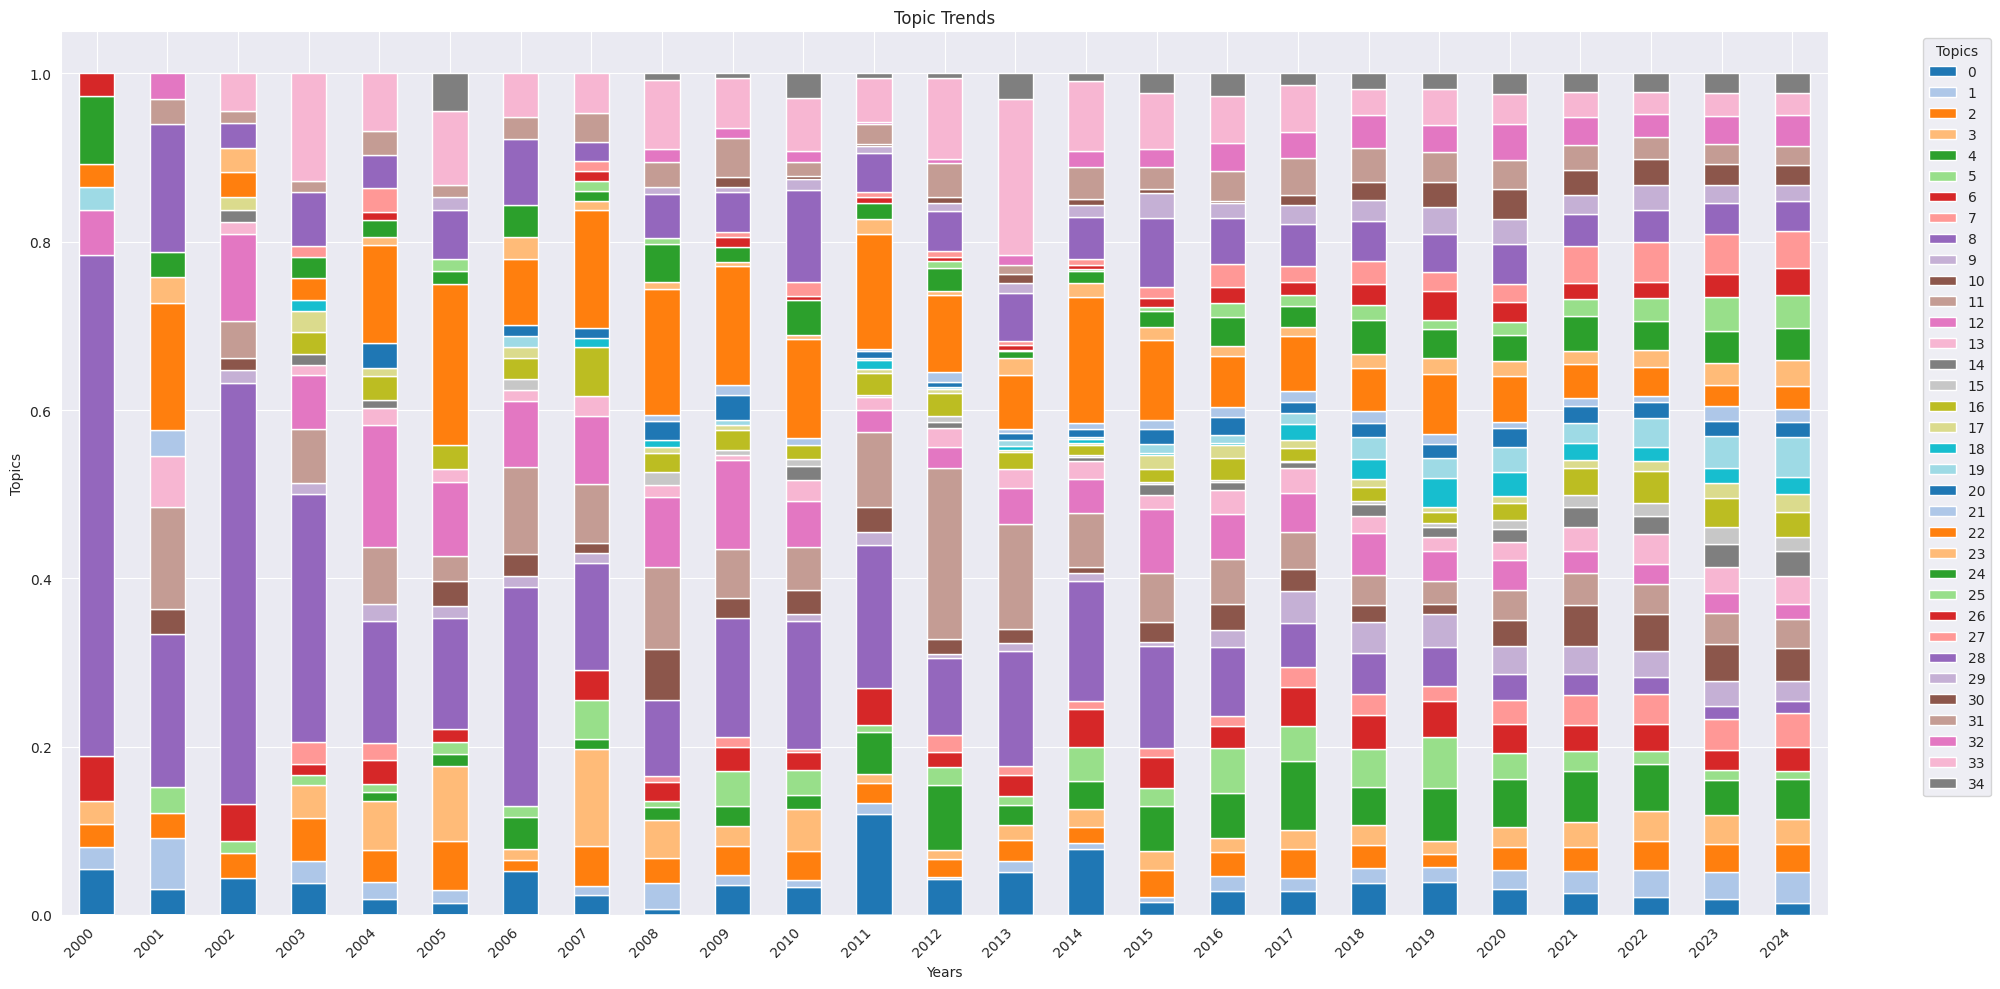

In [35]:
num_topics = len(topic_trend_pivot_normalized.columns)
palette = sns.color_palette("tab20", n_colors=num_topics)

# Plot
fig, ax = plt.subplots(figsize=(max(20, num_topics * 0.5), 10))  # Adjust width dynamically
topic_trend_pivot_normalized.plot(
    kind='bar',
    stacked=True,
    figsize=(20, 10),
    ax=ax,
    color=palette
)

# Adjust legend
ax.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')

# Improve readability of the x-axis labels
plt.xticks(rotation=45, ha='right')

# Add title and labels
plt.title("Topic Trends")
plt.xlabel("Years")
plt.ylabel("Topics")

plt.tight_layout()
plt.show()

<Axes: xlabel='Year'>

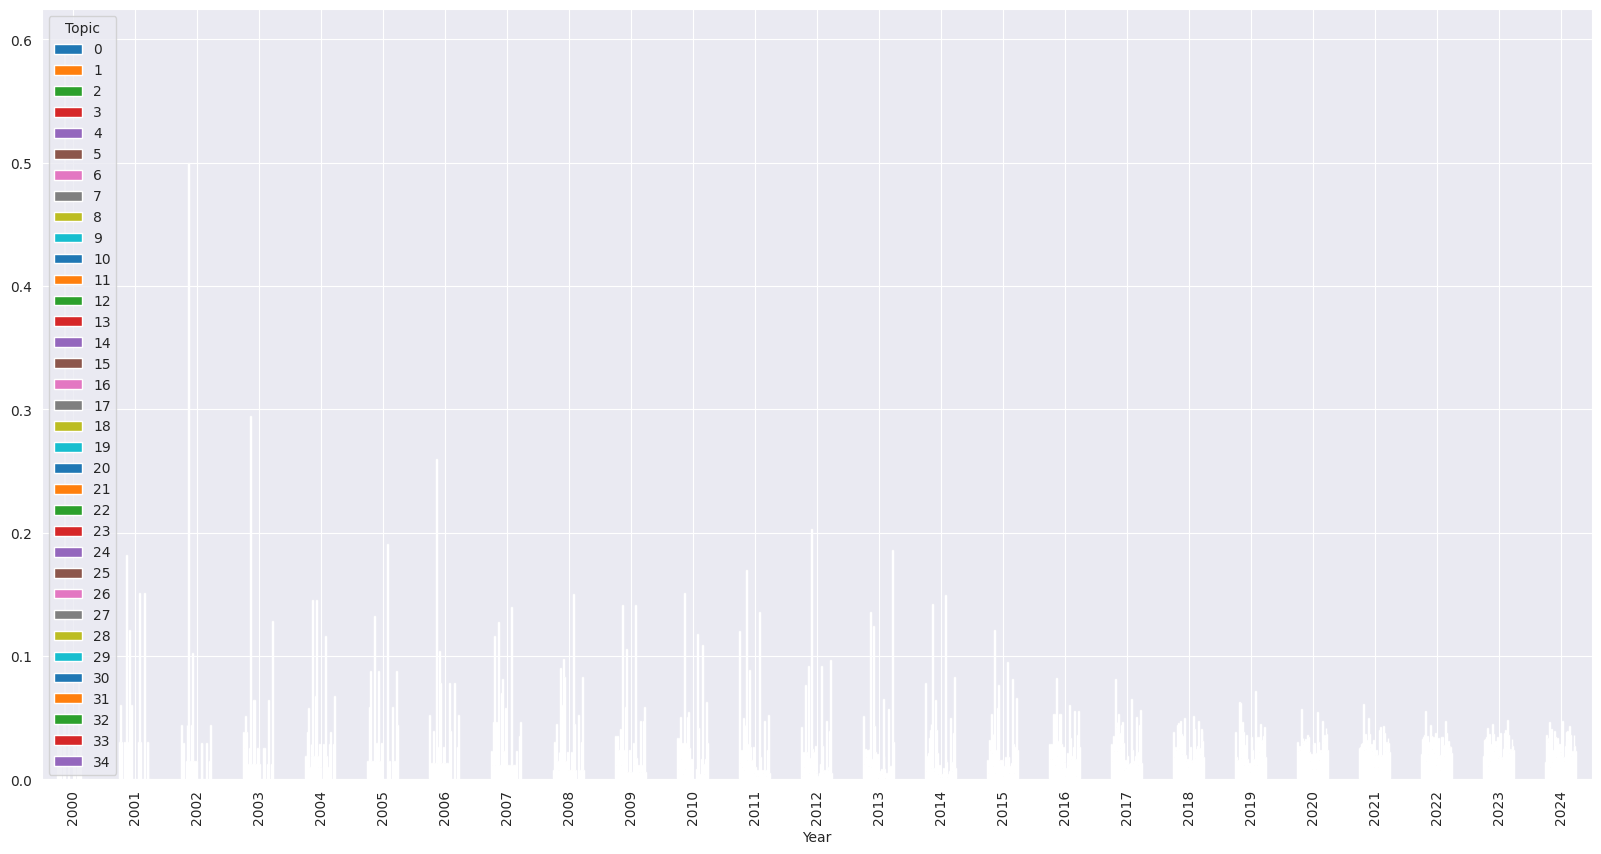

In [36]:
topic_trend_pivot_normalized.plot(kind='bar', figsize=(20, 10))

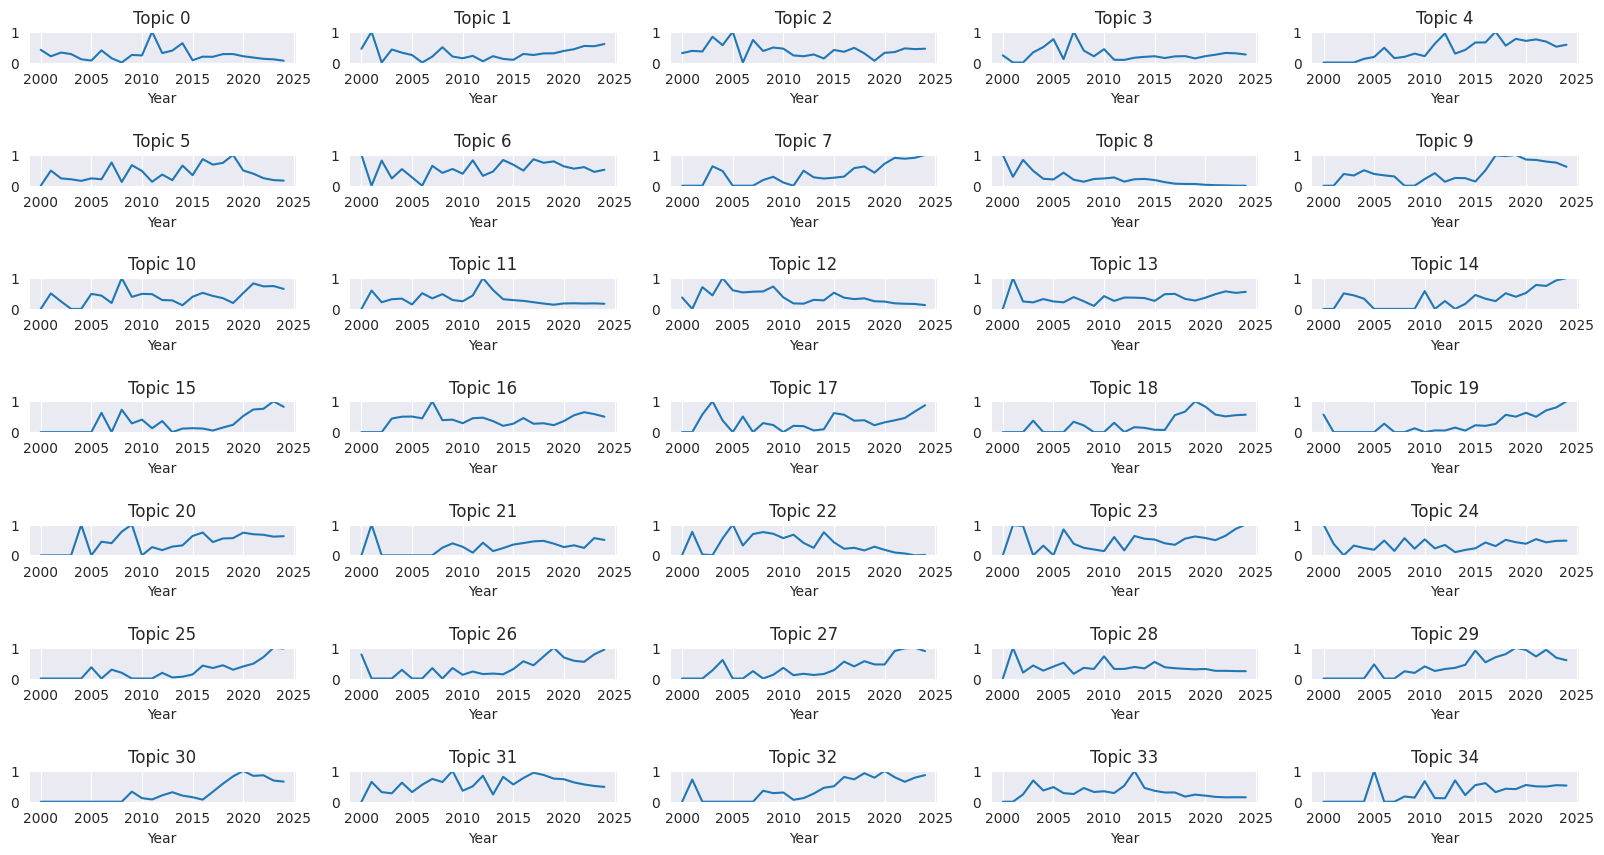

In [37]:
y_min = topic_trend_pivot_normalized_0_1.min().min()
y_max = topic_trend_pivot_normalized_0_1.max().max()

fig, axs = plt.subplots(7, 5, figsize=(20, 10))
for i in range(35):
    topic_trend_pivot_normalized_0_1[i].plot(ax=axs[i//5, i%5], title=f"Topic {i}")
    axs[i//5, i%5].set_ylim(y_min, y_max)  # Set the same y-axis limits for each subplot

plt.subplots_adjust(hspace=3)  # Adjust the height space between rows
plt.show()

### Metrics

In [27]:
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.evaluation_metrics.diversity_metrics import TopicDiversity, InvertedRBO
from octis.evaluation_metrics.similarity_metrics import PairwiseJaccardSimilarity
from octis.evaluation_metrics.topic_significance_metrics import KL_uniform, KL_vacuous, KL_background

In [22]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=30)
top_n_words_list = [top_n_words[i] for i in range(len(top_n_words))]
top_n_words_list = [[tuple[0] for tuple in topic] for topic in top_n_words_list]
top_n_words_list

[['cognitive',
  'intelligence',
  'human',
  'brain',
  'artificial',
  'theory',
  'machine',
  'concept',
  'computational',
  'ai',
  'neural',
  'consciousness',
  'cognition',
  'ability',
  'biological',
  'intelligent',
  'world',
  'computer',
  'memory',
  'mechanism',
  'reasoning',
  'computing',
  'processing',
  'architecture',
  'understanding',
  'symbolic',
  'neuron',
  'structure',
  'evolution',
  'general'],
 ['vehicle',
  'traffic',
  'service',
  'control',
  'scheduling',
  'management',
  'resource',
  'energy',
  'routing',
  'demand',
  'solution',
  'network',
  'transportation',
  'simulation',
  'optimization',
  'time',
  'communication',
  'dynamic',
  'cost',
  'optimal',
  'reinforcement',
  'route',
  'environment',
  'operation',
  'road',
  'algorithm',
  'urban',
  'device',
  'smart',
  'power'],
 ['pruning',
  'architecture',
  'quantization',
  'memory',
  'parameter',
  'layer',
  'neural',
  'training',
  'accuracy',
  'network',
  'weight',
 

In [34]:
# calculate probability that document belongs to topic
centroids = kmeans.cluster_centers_
doc_embeddings = model.dv.vectors

In [35]:
from scipy.spatial.distance import cdist

distances = cdist(doc_embeddings, centroids, 'euclidean')
distances.shape

(34427, 35)

In [36]:
beta = 1.0
weights = np.exp(-beta * distances.T)
weights /= weights.sum(axis=0)

print("N x D Weights Matrix:")
print(weights)

N x D Weights Matrix:
[[0.03709201 0.02542859 0.05122558 ... 0.02384894 0.01693581 0.02119294]
 [0.0168009  0.02543819 0.03144763 ... 0.01885514 0.03281076 0.01874805]
 [0.02286068 0.02692566 0.03023985 ... 0.02667353 0.02741977 0.03594149]
 ...
 [0.01620563 0.02178477 0.01887679 ... 0.01966811 0.03070559 0.10190948]
 [0.01932747 0.01854288 0.01950319 ... 0.018374   0.03085618 0.03280102]
 [0.01899943 0.01881252 0.03510596 ... 0.0271902  0.02565787 0.02075257]]


In [39]:
model_output = dict()
model_output['topics'] = top_n_words_list
model_output['topic-word-matrix'] = tf_idf
model_output["topic-document-matrix"] = weights

In [23]:
from octis.dataset.dataset import Dataset

dataset = Dataset()
dataset.load_custom_dataset_from_folder("../../data/octis")

In [30]:
def calculate_metrics(model_output, dataset, topk=10, verbose=False):
    umass = Coherence(texts=dataset.get_corpus(), topk=topk, measure='u_mass')
    npmi = Coherence(texts=dataset.get_corpus(), topk=topk, measure='c_npmi')
    c_v = Coherence(texts=dataset.get_corpus(), topk=topk, measure='c_v')
    topic_diversity = TopicDiversity(topk=topk)
    inv_rbo = InvertedRBO(topk=topk)
    pairwise_jaccard = PairwiseJaccardSimilarity()
    kl_uniform = KL_uniform()
    kl_vacuous = KL_vacuous()
    kl_background = KL_background()
    metrics = [(umass, 'UMass'), (npmi, 'NPMI'), (c_v, 'C_V'), (topic_diversity, 'Topic Diversity'), (inv_rbo, 'Inverted RBO'), (pairwise_jaccard, 'Pairwise Jaccard'), (kl_uniform, 'KL Uniform'), (kl_vacuous, 'KL Vacuous'), (kl_background, 'KL Background')]
    results = dict()
    for metric, name in metrics:
        try:
            metric_score = metric.score(model_output)
        except:
            metric_score = None
        finally:
            if verbose:
                print(f"{name}: {metric_score}")
            results[name] = metric_score
    return results


In [40]:
metrics = calculate_metrics(model_output, dataset, verbose=True)

UMass: -2.1131777616836716
NPMI: 0.13781809652979066
C_V: 0.6912939261181982
Topic Diversity: 0.7314285714285714
Inverted RBO: 0.9858515674127731
Pairwise Jaccard: 0.011876928273889522
KL Uniform: 2.8718009898330283
KL Vacuous: 9.261963992200151
KL Background: 0.03844930283161817
